# MNIST

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# To easily plot a confusion matrix
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

# EDA

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

print(mnist.DESCR)

c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
# Taking less data to speed up training. 
X_train = X[:5000]
y_train = y[:5000]
X_val = X[5000:6000]
y_val = y[5000:6000]

X_test = X[6000:7000]
y_test = y[6000:7000]

# Standardizing the data (as you generally always should do when using SVM models).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Only transforming the validation data. 
X_test_scaled = scaler.transform(X_test)  # Only transforming the test data. 

The first 3 labels are: 5 0 4


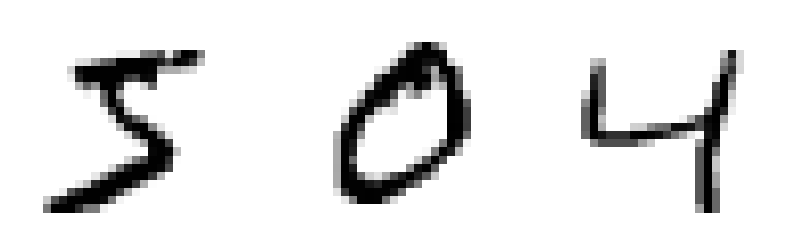

In [5]:
# First 3 labels
print('The first 3 labels are:', y[0], y[1], y[2])

# Plotting the first 3 images of the X data
plt.figure(figsize=(10, 5))
for i in range(3):
    some_digit = X[i]
    some_digit_image = some_digit.reshape(28, 28)
    plt.subplot(1, 3, i + 1)
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.axis("off")

In [6]:
print(X_train_scaled.shape)
print(y_train.shape)

(5000, 784)
(5000,)


# Training models

SVC Accuracy: 0.926


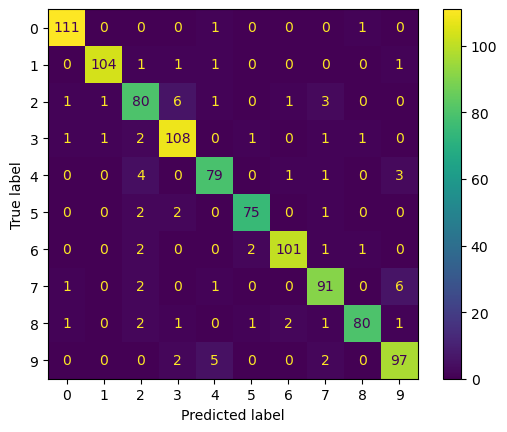

In [7]:
# Test SVC with default settings
svc_clf = SVC(random_state=42)
svc_clf.fit(X_train_scaled, y_train)

y_pred_svc = svc_clf.predict(X_val_scaled)

display_confusion_matrix(y_val, y_pred_svc)

print("SVC Accuracy:", accuracy_score(y_val, y_pred_svc))

RandomForest Accuracy: 0.939


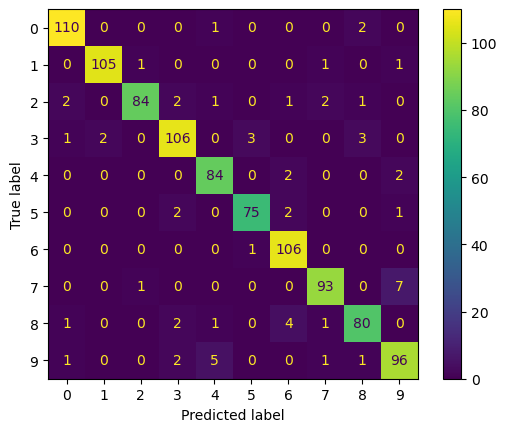

In [8]:
# Test RandomForest with default settings
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)

y_pred_rf = rf_clf.predict(X_val_scaled)

display_confusion_matrix(y_val, y_pred_rf)

print("RandomForest Accuracy:", accuracy_score(y_val, y_pred_rf))

They are close but Random Forest is slightly better out of the box.

Let's see if we can find better parameters

In [9]:
# Find best params for SVC
svm_clf = SVC(random_state=42)

hyper_param_grid = [{
    'kernel': ['rbf', 'poly']
    , 'gamma': [0.05, 0.075, 0.1]
    , 'C': [0.0001, 0.001]
}]

gs_svm = GridSearchCV(svm_clf, hyper_param_grid, cv = 3)
gs_svm.fit(X_train_scaled, y_train)

gs_svm.best_params_

{'C': 0.001, 'gamma': 0.05, 'kernel': 'poly'}

Improved SVC Accuracy: 0.939


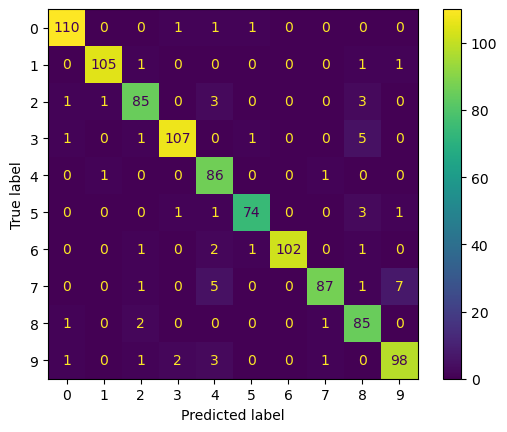

In [10]:
y_pred_gs_svm = gs_svm.predict(X_val_scaled)

display_confusion_matrix(y_val, y_pred_gs_svm)

print("Improved SVC Accuracy:", accuracy_score(y_val, y_pred_gs_svm))

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_clf = SVC(random_state=42)

param_distributions = {"gamma": reciprocal(0.001, 0.1)
                       , "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train)

rnd_search_cv.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=7.1400188011736745, gamma=0.08947660928834364; total time=  12.1s
[CV] END ....C=7.1400188011736745, gamma=0.08947660928834364; total time=  11.9s
[CV] END ....C=7.1400188011736745, gamma=0.08947660928834364; total time=  12.0s
[CV] END ...C=8.506443125736787, gamma=0.0014328234733124035; total time=   4.6s
[CV] END ...C=8.506443125736787, gamma=0.0014328234733124035; total time=   4.9s
[CV] END ...C=8.506443125736787, gamma=0.0014328234733124035; total time=   4.9s
[CV] END ...C=3.5121895684343762, gamma=0.004084993257633549; total time=   8.3s
[CV] END ...C=3.5121895684343762, gamma=0.004084993257633549; total time=   8.5s
[CV] END ...C=3.5121895684343762, gamma=0.004084993257633549; total time=   7.8s
[CV] END ....C=2.656435899652452, gamma=0.001153335897284423; total time=   4.2s
[CV] END ....C=2.656435899652452, gamma=0.001153335897284423; total time=   4.5s
[CV] END ....C=2.656435899652452, gamma=0.001153

{'C': 10.684641636627177, 'gamma': 0.0010060591150504652}

Improved SVC Accuracy: 0.932


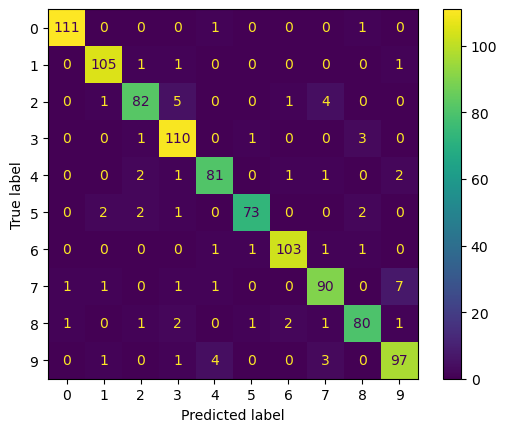

In [12]:
y_pred_rnd_search = rnd_search_cv.predict(X_val_scaled)

display_confusion_matrix(y_val, y_pred_rnd_search)

print("Improved SVC Accuracy:", accuracy_score(y_val, y_pred_rnd_search))

In [14]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid = [{ 
    'n_estimators': [200, 500]
    , 'max_features': ['auto', 'sqrt', 'log2']
    , 'criterion' :['gini', 'entropy']
}]

gs_rf = GridSearchCV(rf_clf, param_grid, cv = 3)
gs_rf.fit(X_train_scaled, y_train)

gs_rf.best_params_

c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  F

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}

Improved Random Forest Accuracy: 0.94


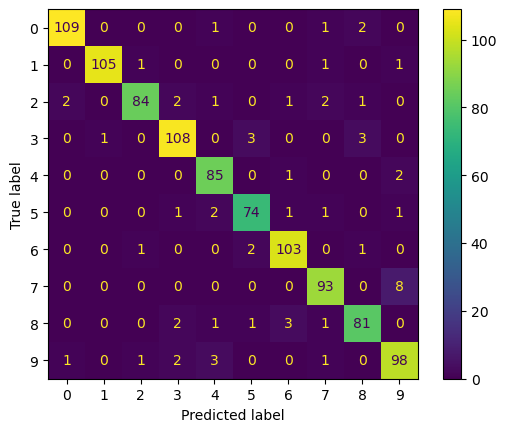

In [15]:
y_pred_gs_rf = gs_rf.predict(X_val_scaled)

display_confusion_matrix(y_val, y_pred_gs_rf)

print("Improved Random Forest Accuracy:", accuracy_score(y_val, y_pred_gs_rf))

In [16]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid = [{
    'n_estimators': np.arange(100, 500, 100)
    , 'max_features': ['auto', 'sqrt', 'log2']
    , 'criterion': ['gini', 'entropy']
}]

rs_rf = RandomizedSearchCV(rf_clf, param_grid, n_iter=10, cv=3)
rs_rf.fit(X_train_scaled, y_train)

rs_rf.best_params_

c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  Fil

{'n_estimators': 400, 'max_features': 'sqrt', 'criterion': 'entropy'}

Improved Random Forest Accuracy: 0.939


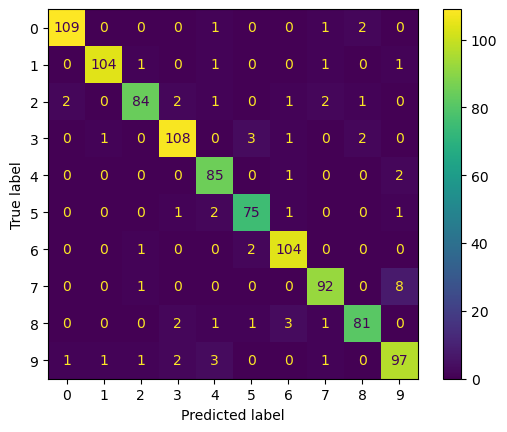

In [17]:
y_pred_rs_rf = rs_rf.predict(X_val_scaled)

display_confusion_matrix(y_val, y_pred_rs_rf)

print("Improved Random Forest Accuracy:", accuracy_score(y_val, y_pred_rs_rf))

# Evaluate on test data

Since the improved models could only marginally improve on the initial Random Forest Model we choose that one since it is much quicker than spending time on finding better parameters than only incrementaly improve the model.

Accuracy test score: 0.937


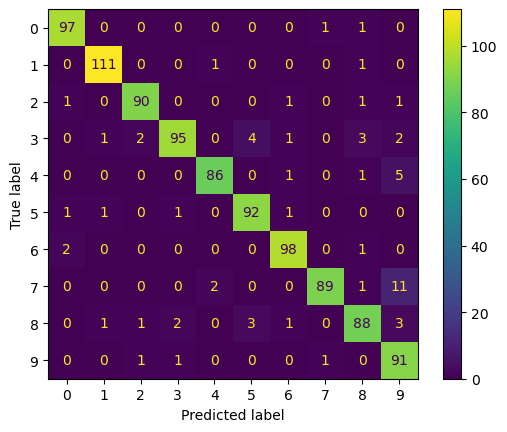

In [18]:
rf_clf.fit(X_train_scaled, y_train)

y_pred_test = rf_clf.predict(X_test_scaled)

print('Accuracy test score:', accuracy_score(y_test, y_pred_test))

display_confusion_matrix(y_test, y_pred_test)